In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import gymnasium as gym
from tqdm import tqdm
import seaborn as sns
import pickle

In [2]:

# Initialize Blackjack environment
env = gym.make("Blackjack-v1", sab=True, render_mode=None)

# Initialize Q-values and policy
Q = defaultdict(lambda: np.zeros(env.action_space.n))
returns_sum = defaultdict(float)
returns_count = defaultdict(float)

# Hyperparameters
episodes = 1_000_000
# Discount factor
gamma = 1.0

# Exploration rate
# epsilon = 0.1
# Initial exploration rate
epsilon_start = 1.0
# Minimum exploration rate
epsilon_end = 0.05
# Decay rate
epsilon_decay = 0.999995
epsilon = epsilon_start

# Track reward per episode
reward_per_episode = []

# Monte Carlo Control with epsilon-greedy policy
for i in tqdm(range(episodes), desc="Training Agent"):
    episode = []
    state, _ = env.reset()
    done = False

    while not done:
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode.append((state, action, reward))
        state = next_state

    reward_per_episode.append(reward)

    # First-visit Monte Carlo update
    G = 0
    visited = set()
    for t in reversed(range(len(episode))):
        state, action, reward = episode[t]
        G = gamma * G + reward
    # for state, action, reward in reversed(episode):
    #     # Final reward only
    #     G = reward  
        if (state, action) not in visited:
            returns_sum[(state, action)] += G
            returns_count[(state, action)] += 1
            Q[state][action] = returns_sum[(state, action)] / returns_count[(state, action)]
            visited.add((state, action))
    epsilon = max(epsilon_end, epsilon * epsilon_decay)

# Derive optimal policy from Q-table
# policy = {state: np.argmax(actions) for state, actions in Q.items()}
# print("Sample Learned Policy (state -> action):")
# for k in list(policy.items())[:10]:
#     print(k)
policy = {}
for state, actions in Q.items():
    player_sum, dealer_card, usable_ace = state
    if 12 <= player_sum <= 21 and 1 <= dealer_card <= 10:
        policy[state] = np.argmax(actions)

Training Agent: 100%|██████████| 1000000/1000000 [01:31<00:00, 10880.38it/s]


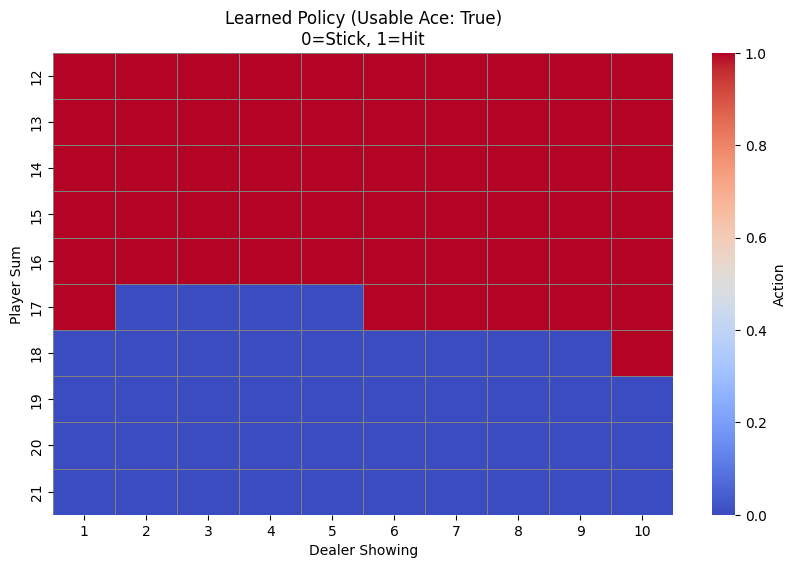

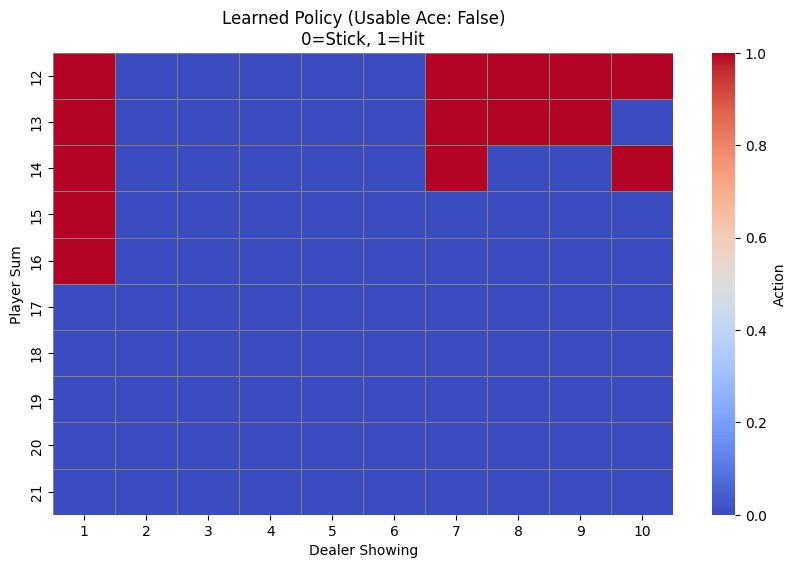

In [3]:
# Visualize the learned policy as a heatmap
def plot_policy(policy, usable_ace=True):
    player_range = np.arange(12, 22)
    dealer_range = np.arange(1, 11)
    policy_map = np.zeros((len(player_range), len(dealer_range)))

    for i, player in enumerate(player_range):
        for j, dealer in enumerate(dealer_range):
            state = (player, dealer, usable_ace)
            action = policy.get(state, -1)
            policy_map[i, j] = action

    plt.figure(figsize=(10, 6))
    sns.heatmap(policy_map, xticklabels=dealer_range, yticklabels=player_range, cmap="coolwarm", cbar_kws={'label': 'Action'}, linewidths=.5, linecolor='gray')
    plt.title(f"Learned Policy (Usable Ace: {usable_ace})\n0=Stick, 1=Hit")
    plt.xlabel("Dealer Showing")
    plt.ylabel("Player Sum")
    plt.show()

# Plot learned policy
plot_policy(policy, usable_ace=True)
plot_policy(policy, usable_ace=False)

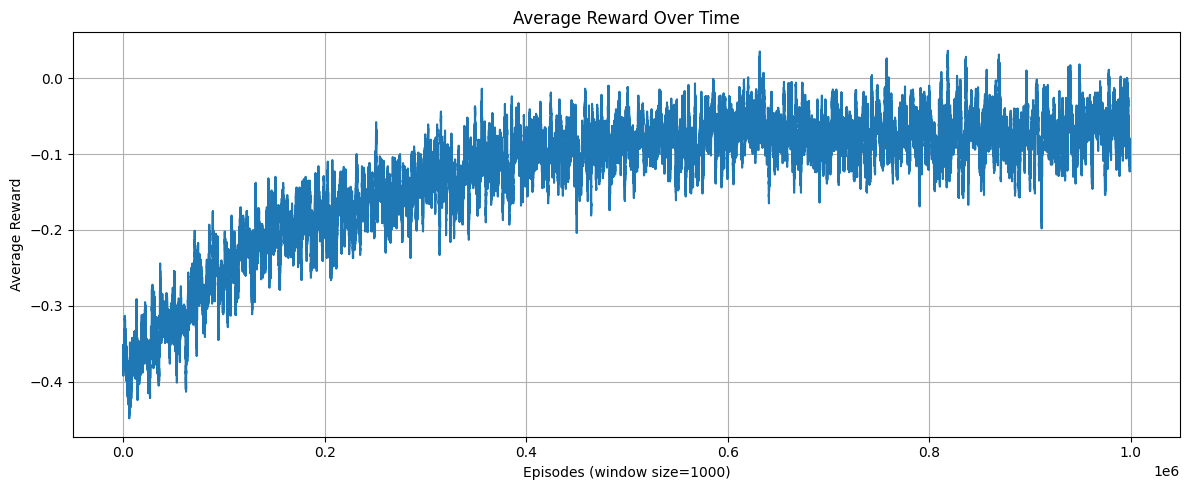

In [4]:
# Plot average reward over time
def plot_average_reward(rewards, window=1000):
    moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
    plt.figure(figsize=(12, 5))
    plt.plot(moving_avg)
    plt.title("Average Reward Over Time")
    plt.xlabel(f"Episodes (window size={window})")
    plt.ylabel("Average Reward")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Visualize reward trend
plot_average_reward(reward_per_episode)

In [5]:
# After training in Monte Carlo code
with open('blackjack.pkl', 'wb') as file:
    pickle.dump(policy, file)